## Laboratorio 5 - Modelación y Simulación
### Ejercicio 1

Stefano Aragoni, Carol Arévalo, Luis Santos

----------------

#### Ejercicio 1 - Depredador - Presa
Debe crear una simulación de depredador-presa utilizando modelos basados en agentes. Modele varios tipos de
depredadores con diferentes comportamientos y agregue obstáculos que afecten los movimientos de los agentes.

Requisitos:
- Cree una clase Predator con diferentes subclases para diferentes tipos de depredadores.
- Modele diferentes comportamientos para distintos tipos de depredadores, como depredadores "cazadores" que persiguen activamente a sus presas y depredadores "emboscadores" que esconden y sorprenden a sus presas.
- Agregue obstáculos que los agentes deben rodear.
- Simule los movimientos de los agentes y visualice sus interacciones

----------------

#### Librerías

En esta sección se importan las librerías necesarias para el desarrollo del ejercicio. Asimismo, se definen las constantes que se utilizarán en el ejercicio.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import uuid
from PIL import Image
from IPython.display import display, Image as IPImage

map = 100
num_steps = 70
num_prey = 100
num_predators = 5
num_obs = 10

-----------

#### Clases de Agentes

En esta sección se declaraon las clases de los siguientes agentes:
- Obstacle
- Predator
    - Hunter
    - Ambusher
- Prey

In [72]:
class Obstacle():
    def __init__(self, x, y):
        self.position = np.array([x, y])

In [73]:
class Predator():
    def __init__(self, x, y, tipo):
        self.position = np.array([x, y])
        self.instance_hash = uuid.uuid4().hex
        self.type = tipo

In [74]:
class Hunter(Predator):
    def __init__(self, x, y):
        super().__init__(x, y, 'hunter')
        self.speed = 8
    
    def update(self, prey_list, obstacle_list):
        # ------------------------------------------------------------
        # Regla 0: Presas vivas - Revisar si hay presas vivas en el mapa
        if len(prey_list) == 0:
            # No hay presas vivas, no hacer nada
            return

        # ------------------------------------------------------------
        # Regla 1: Cazar - Si hay una presa en el range de caza, cazarla
        closest_prey = min(prey_list, key=lambda prey: np.linalg.norm(self.position - prey.position))

        if np.linalg.norm(self.position - closest_prey.position) <= self.speed:
            # Capturar presa
            self.position = closest_prey.position
            return

        # ------------------------------------------------------------
        # Regla 2: Perseguir a la presa más cercana - Moverse hacia la presa más cercana si esta en el rango de visión
        closest_prey = min(prey_list, key=lambda prey: np.linalg.norm(self.position - prey.position))

        if np.linalg.norm(self.position - closest_prey.position) < 20:
            # Si la presa está cerca, moverse hacia ella
            direction =  closest_prey.position - self.position             # Dirección hacia la presa
            direction = direction / np.linalg.norm(direction)              # Normalizar la dirección

        else:
            # Si la presa está lejos, moverse aleatoriamente
            if np.random.random() < 0.5:
                direction = np.random.random(2) * 2 - 1                      # Moverse aleatoriamente
            else:
                direction = np.array([0, 0])

        # ------------------------------------------------------------
        # Regla 3: Evitar obstáculos - Moverse alejándose de los obstáculos cercanos

        closest_obstacle = min(obstacle_list, key=lambda obstacle: np.linalg.norm(self.position - obstacle.position))
        if np.linalg.norm(self.position - closest_obstacle.position) < 5:
            # Si el obstáculo está cerca, alejarse de él
            obstacle_direction = self.position - closest_obstacle.position
            obstacle_direction = obstacle_direction / np.linalg.norm(obstacle_direction)

        else:
            obstacle_direction = np.array([0, 0])

        direction = (direction + obstacle_direction) / 2

        if np.linalg.norm(direction) > 0:       # Si la dirección normalizada no es cero, moverse en esa dirección
            direction_normalized = direction / np.linalg.norm(direction)
            new_position = self.position + direction_normalized * self.speed
        else:                                   # Si la dirección normalizada es cero, moverse aleatoriamente
            direction_random = np.random.random(2) * 2 - 1
            new_position = self.position + direction_random * self.speed

        # ------------------------------------------------------------
        # Regla 4: Que no se salga del mapa - Restringir la nueva posición dentro de los límites del mapa
        new_position = np.clip(new_position, 0, map - 1)

        self.position = new_position

In [75]:
class Ambusher(Predator):
    def __init__(self, x, y):
        super().__init__(x, y, 'ambusher')
        self.speed = 6
    
    def update(self, prey_list, obstacle_list):
        # ------------------------------------------------------------
        # Regla 0: Presas vivas - Revisar si hay presas vivas en el mapa
        if len(prey_list) == 0:
            # No hay presas vivas, no hacer nada
            return

        # ------------------------------------------------------------
        # Regla 1: Cazar - Si hay una presa en el range de caza, cazarla
        closest_prey = min(prey_list, key=lambda prey: np.linalg.norm(self.position - prey.position))

        if np.linalg.norm(self.position - closest_prey.position) <= self.speed*2:
            # Capturar presa
            self.position = closest_prey.position
            return
        
        # ------------------------------------------------------------
        # Regla 2: Moverse al obstaculo mas cercano para emboscar
        closest_obstacle = min(obstacle_list, key=lambda obstacle: np.linalg.norm(self.position - obstacle.position))

        # Si el ambusher está cerca del obstaculo, no hacer nada
        if np.linalg.norm(self.position - closest_obstacle.position) < 3:
            return

        # Si el obstaculo esta a menos de la velocidad, moverse al obstaculo
        elif np.linalg.norm(self.position - closest_obstacle.position) <= self.speed:
            # Acercarse al obstaculo en un paso
            new_position = closest_obstacle.position

        # Si el obstaculo esta a mas de la velocidad, moverse en la direccion del obstaculo
        else:
            obstacle_direction = self.position - closest_obstacle.position
            obstacle_direction = obstacle_direction / np.linalg.norm(obstacle_direction)
            obstacle_direction = -obstacle_direction

            new_position = self.position + obstacle_direction * self.speed

        # ------------------------------------------------------------
        # Regla 3: Que no se salga del mapa - Restringir la nueva posición dentro de los límites del mapa
        new_position = np.clip(new_position, 0, map - 1)

        self.position = new_position

In [76]:
class Prey():
    def __init__(self, x, y):
        self.position = np.array([x, y])
        self.alive = True
        self.instance_hash = uuid.uuid4().hex
        self.speed = np.random.randint(5, 8)
    
    def update(self, predator_list, obstacle_list):

        # ------------------------------------------------------------
        # Regla 0: Que no se lo coma el depredador - Verificar si el depredador lo atrapó
        closest_predator = min(predator_list, key=lambda predator: np.linalg.norm(self.position - predator.position))
        if np.linalg.norm(self.position - closest_predator.position) < 3:
            self.alive = False
            return

        # ------------------------------------------------------------
        # Regla 1: Escapar de depredador - Huir del depredador más cercano
        closest_predator = min(predator_list, key=lambda predator: np.linalg.norm(self.position - predator.position))

        if np.linalg.norm(self.position - closest_predator.position) < 10:
            # Si el depredador está cerca, huir de él
            direction = self.position - closest_predator.position           # Calcular la dirección hacia el depredador más cercano 
            direction = direction / np.linalg.norm(direction)               # Normalizar la dirección

        else:
            # Si el depredador está lejos, moverse o no moverse aleatoriamente
            if np.random.random() < 0.5:
                direction = np.random.random(2) * 2 - 1                      # Moverse aleatoriamente
            else:
                direction = np.array([0, 0])

        # ------------------------------------------------------------
        # Regla 2: Evitar obstáculos - Evitar el obstáculo más cercano
        closest_obstacle = min(obstacle_list, key=lambda obstacle: np.linalg.norm(self.position - obstacle.position))
        if np.linalg.norm(self.position - closest_obstacle.position) < 8:
            # Si el obstáculo está cerca, alejarse de él
            obstacle_direction = self.position - closest_obstacle.position
            obstacle_direction = obstacle_direction / np.linalg.norm(obstacle_direction)

        else:
            obstacle_direction = np.array([0, 0])

        # ------------------------------------------------------------
        # Regla 3: Alejarse de depredadores y obstáculos
        direction = (direction + obstacle_direction) / 2

        if np.linalg.norm(direction) > 0:       # Si la dirección normalizada no es cero, moverse en esa dirección
            direction_normalized = direction / np.linalg.norm(direction)
            new_position = self.position + direction_normalized * self.speed
        else:                                   # Si la dirección normalizada es cero, moverse aleatoriamente
            direction_random = np.random.random(2) * 2 - 1
            new_position = self.position + direction_random * self.speed

        # ------------------------------------------------------------
        # Regla 4: Que no se salga del mapa - Restringir la nueva posición dentro de los límites del mapa
        new_position = np.clip(new_position, 0, map - 1)

        self.position = new_position


-------

#### Creación de agentes

En esta sección se crean los agentes que se utilizarán en la simulación. Se aleatorizan las posiciones de los agentes en el espacio de simulación.

- Obstáculos

In [77]:
obstacles = []
positions = ["-1,-1"]

for i in range(num_obs):

    x = np.random.randint(0, map-5)
    y = np.random.randint(0, map-5)

    for j in range(0, 6):
        for k in range(0, 6):
            obstacles.append(Obstacle(x, y))
            positions.append(str(x) + "," + str(y))

            x += 1

        x -= 6
        y += 1

- Depredadores

In [78]:
predators = []

for i in range(0, num_predators):
    x = -1
    y = -1

    while str(x) + "," + str(y) in positions:
        x = np.random.randint(0, map-1)
        y = np.random.randint(0, map-1)

    if len(predators) < num_predators/2:
        predators.append(Hunter(x, y))
    else:
        predators.append(Ambusher(x, y))

- Presas

In [79]:
prey = []

for i in range(0, num_prey):
    x = -1
    y = -1

    while str(x) + "," + str(y) in positions:
        x = np.random.randint(0, map-1)
        y = np.random.randint(0, map-1)

    prey.append(Prey(x, y))

----------------

#### Simulación

En esta sección se simula el funcionamiento de los agentes. Se definen las reglas de comportamiento de los agentes y se ejecuta la simulación.

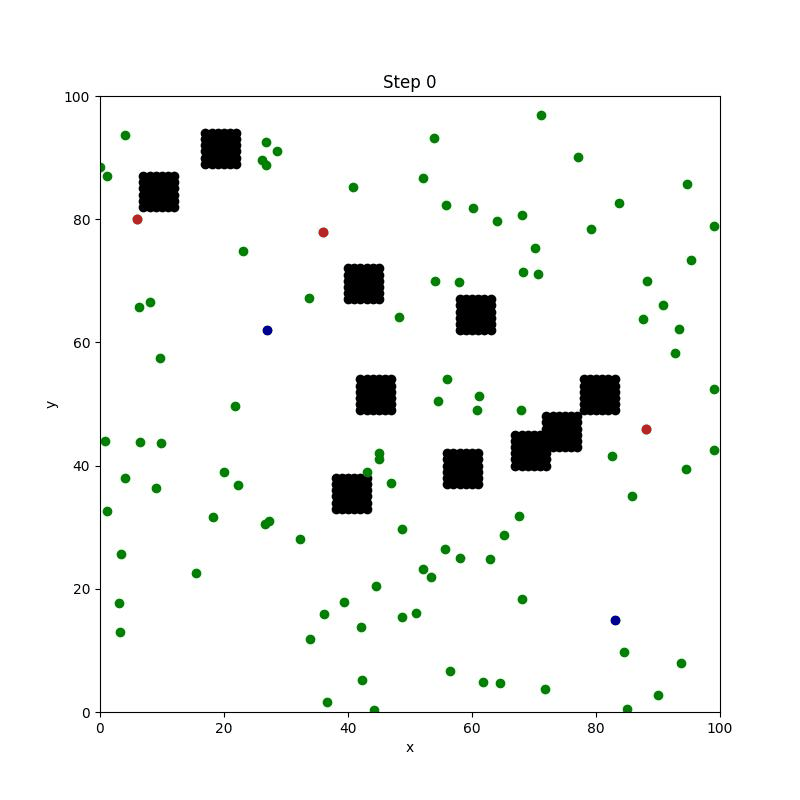

In [80]:
list_images = []

for step in range(num_steps):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, map)
    plt.ylim(0, map)
    
    prey_positions = np.array([p.position for p in prey if p.alive])
    predator_positions = np.array([p.position for p in predators])

    for obstacle in obstacles:
        plt.plot(obstacle.position[0], obstacle.position[1], 'ko')
    
    if prey_positions.shape[0] > 0:
        for predator in predators:
            predator.update(prey, obstacles)
        
        died_prey = []
        for p in prey:
            if p.alive:
                p.update(predators, obstacles)
                plt.plot(p.position[0], p.position[1], 'go')
            
            if not p.alive:
                died_prey.append(p)

        for p in died_prey:
            prey.remove(p)
        
        for predator in predators:
            if predator.type == 'hunter':
                plt.plot(predator.position[0], predator.position[1], 'ro')
            else:
                plt.plot(predator.position[0], predator.position[1], 'bo')
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Step " + str(step))
    name = "images1/step_" + str(step) + ".jpg"
    plt.savefig(name, format="jpg")
    plt.close()
    list_images.append(name)

# Crear el GIF
images = [Image.open(path) for path in list_images]
images[0].save('predator_prey_simulation.gif', save_all=True, append_images=images[1:], loop=0, duration=200)

# Mostrar el GIF
display(IPImage("predator_prey_simulation.gif"))

EMBOZCADORES = azules
CAZADORES = rojos

PRESAS = verdes

OBSTÁCULOS = negro

------

#### Preguntas

1. ¿Qué comportamientos puede observar en los depredadores?

En el caso de los cazadores, se puede observar cómo estos navegan el mapa hasta que encuentran alguna presa cerca. Una vez que la encuentran, la persiguen hasta que la alcanzan y la devoran. En el caso de los emboscadores, se puede observar cómo estos se esconden en un lugar del mapa y esperan a que una presa pase cerca para atacarla.

Como resultado, se puede observar como los cazadores se mueven más que los emboscadores. Asimismo, debido a que se mueven más, los cazadores tienen más posibilidades de encontrar una presa que los emboscadores.


Finalmente, también es importante mencionar que debido a que los cazadores se mueven constantemente, estos tienen más probabilidad de explorar el mapa. Sin emabrgo, los embozcadores se suelen quedar en un único cuadrante.

2. ¿Cómo mejoraría este modelo?

Nosotros mejoraríamos este modelo a través de hacer que los embozcadores circularan los obstáculos. De esta forma, no se quedarían tan quietos y serían capaces de explorar más el mapa. Por ejemplo, ahorita se quedan totalmente quietos en una sección de un obstáculo, pero si lo circularan, podrían ver qué más se encuentra al rededor del mismo. 

En el caso de los cazadores y presas, cambiaríamos el comportamiento de moviemiento aleatorio. En vez de moverse de forma aleatoria, estos podrían seguir como líneas rectas y después hacer giros. Ya que ahorita se mueven de forma aleatoria, a veces se mueven y regresan a su posición de antes. 

Finalmente, también se podría mejorar a través de hacer más obstáculos de diferentes formas. De esta manera se podría hacer que la simulación fuera más dinámica. Incluso, se podía hasta incluir lugares de escondite para las presas. 

